### In this case I'm going to upload data with pandahouse from Clickhouse database and analyze it in Python

In [1]:
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

#### Specify parameters for connection

In [2]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [13]:
connection_test = dict(database='test',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student-rw',
                  password='656e2b0c9c')

In [14]:
q = '''
SELECT 
    UserID
FROM
    default.checks
ORDER BY UserID DESC
LIMIT 10
'''

In [15]:
q_test = ph.read_clickhouse(query = q, connection = connection_default)
q_test

,UserID
0,18446738559901903527
1,18446736855775843161
2,18446736855775843161
3,18446736855775843161
4,18446736855775843161
5,18446736855775843161
6,18446736855775843161
7,18446736855775843161
8,18446736855775843161
9,18446736855775843161


In [16]:
q2 = """
CREATE TABLE test.example_table_hohlov_v (
    id UInt32,
    supplementary_id UInt32,
    comments String 
) 
ENGINE = MergeTree 
ORDER BY (id, supplementary_id)
"""
ph.execute(query=q2, connection=connection_test)

b''

In [18]:
df = pd.DataFrame({'id': [1, 2, 3], 'supplementary_id': [3, 4, 5], 'comments': ['smth', 'smth', 'smth']})
df

,id,supplementary_id,comments
0,1,3,smth
1,2,4,smth
2,3,5,smth


In [21]:
ph.to_clickhouse(df, 'example_table_hohlov_v', index=False, connection=connection_test)

3

In [22]:
query_test = """
SELECT *
FROM test.example_table_hohlov_v
"""

df_new = ph.read_clickhouse(query_test, connection=connection_test)

In [23]:
df_new

,id,supplementary_id,comments
0,1,3,smth
1,2,4,smth
2,3,5,smth


#### Output simple query: number of rows in data table

In [5]:
# простой запрос: выведите количество строк в таблице ldn_listings
q = '''
SELECT count(*)
FROM ldn_listings
'''
ph.execute(query=q, connection=connection_default)

b'85207\n'

#### Upload prices depends on accommodation types: 

In [10]:
q2 = '''
SELECT room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
GROUP BY room_type, id, price
ORDER BY id
LIMIT 1000
'''
df_n = ph.read_clickhouse(q2, connection=connection_default)

#### Let's take 75 percentile of price for Private room as a result:  

In [14]:
df_n.query('room_type == "Private room"').price.quantile(0.75)

70.0

#### Take additional data such as - room ratio. Get price mean and ratio mean. Get scatterplot for mean prices depends on rating   

In [88]:
q3 = '''
SELECT room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM ldn_listings
WHERE isNotNull(review_scores_rating)
GROUP BY room_type, price, review_scores_rating
LIMIT 1000
'''
df_m = ph.read_clickhouse(q3, connection=connection_default)
df_m

,room_type,price,review_scores_rating
0,Entire home/apt,196.0,80.0
1,Private room,76.0,95.0
2,Private room,167.0,92.0
3,Entire home/apt,247.0,95.0
4,Private room,149.0,72.0
...,...,...,...
995,Entire home/apt,477.0,90.0
996,Entire home/apt,59.0,94.0
997,Entire home/apt,91.0,75.0
998,Private room,200.0,100.0


In [89]:
df_m = df_m.groupby('room_type').agg({'price': 'mean', 'review_scores_rating': 'mean'})

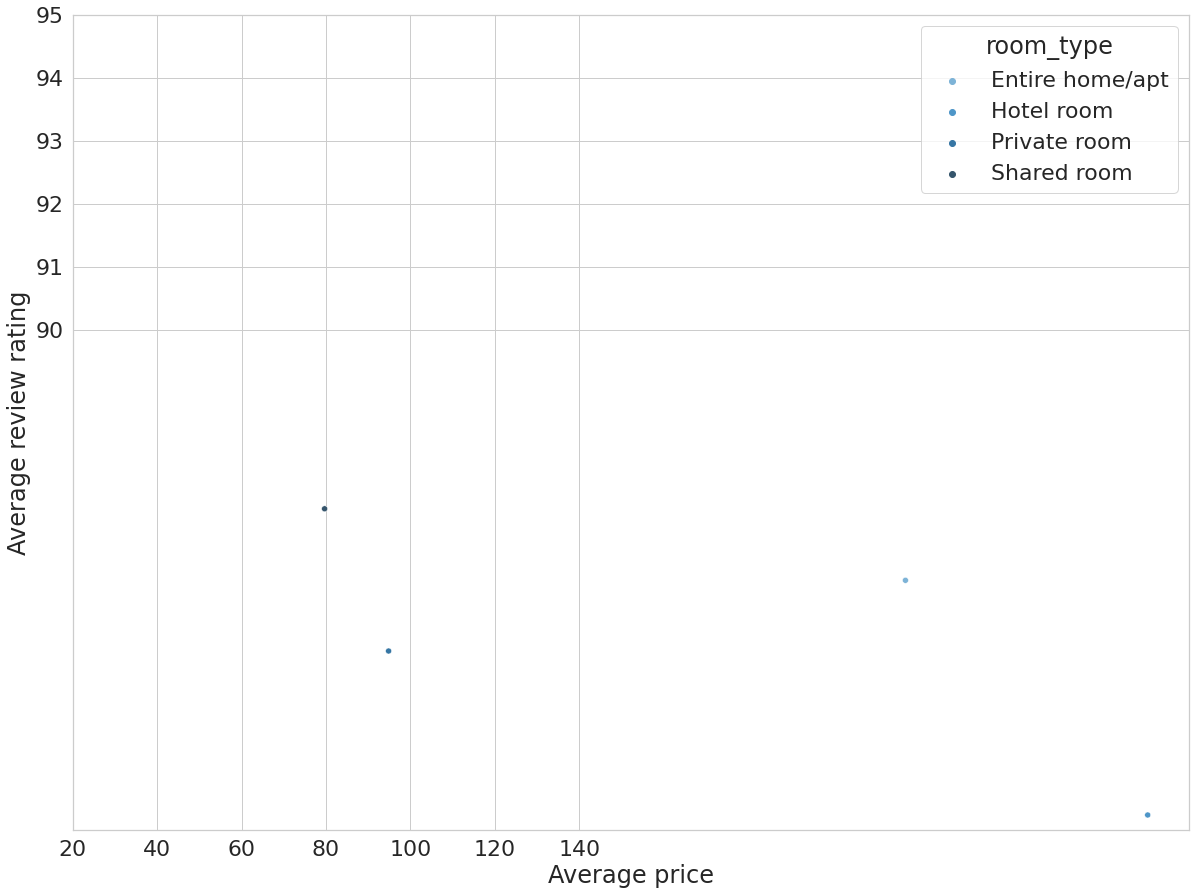

In [175]:
sns.set(font_scale = 2, 
        style      = 'whitegrid', 
        rc         = {'figure.figsize': (20, 15)}
       )

ax = sns.scatterplot(data = df_m, x = 'price', y = 'review_scores_rating', hue = 'room_type', palette = 'Blues_d')

ax.set(xlabel='Average price', ylabel='Average review rating')
ax.set_xticks([i for i in range(20, 160, 20)])
ax.set_yticks([i for i in range(90, 96)])

In [90]:
df_m

,price,review_scores_rating
room_type,,
Entire home/apt,217.333328,86.032410
Hotel room,274.741394,82.310349
Private room,94.833336,84.911110
Shared room,79.666664,87.166664


#### Check out host verifications:

In [164]:
q4 = '''
SELECT DISTINCT(host_id), host_verifications 
FROM ldn_listings
WHERE experiences_offered != 'none'
'''
df_v = ph.read_clickhouse(q4, connection=connection_default)
df_v.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [165]:
df_v.host_verifications

0       ['email', 'phone', 'facebook', 'reviews', 'off...
1       ['email', 'phone', 'reviews', 'jumio', 'govern...
2       ['email', 'phone', 'jumio', 'selfie', 'governm...
3       ['email', 'phone', 'manual_offline', 'jumio', ...
4       ['email', 'phone', 'reviews', 'offline_governm...
                              ...                        
1356    ['email', 'phone', 'reviews', 'jumio', 'govern...
1357    ['email', 'phone', 'reviews', 'jumio', 'offlin...
1358    ['email', 'phone', 'reviews', 'jumio', 'govern...
1359    ['email', 'phone', 'google', 'reviews', 'jumio...
1360    ['email', 'phone', 'reviews', 'manual_offline'...
Name: host_verifications, Length: 1361, dtype: object

#### Clean it for further step and get statistics about verification types:

In [166]:
df_v = df_v.host_verifications.apply(lambda x: x.strip('[]').replace('\'', '').replace(' ', '').split(','))

In [167]:
df_v.explode('host_verifications').value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

#### Which experiences will be offered in different districts? 

In [170]:
q5 = '''
SELECT neighbourhood_cleansed, experiences_offered, COUNT(id) AS experiences_count
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
'''
df_y = ph.read_clickhouse(q5, connection=connection_default)
df_y

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [172]:
df_y = df_y.pivot(index = 'neighbourhood_cleansed', columns = 'experiences_offered', values = 'experiences_count')

In [173]:
df_y

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


#### Visualize it with heatmap:

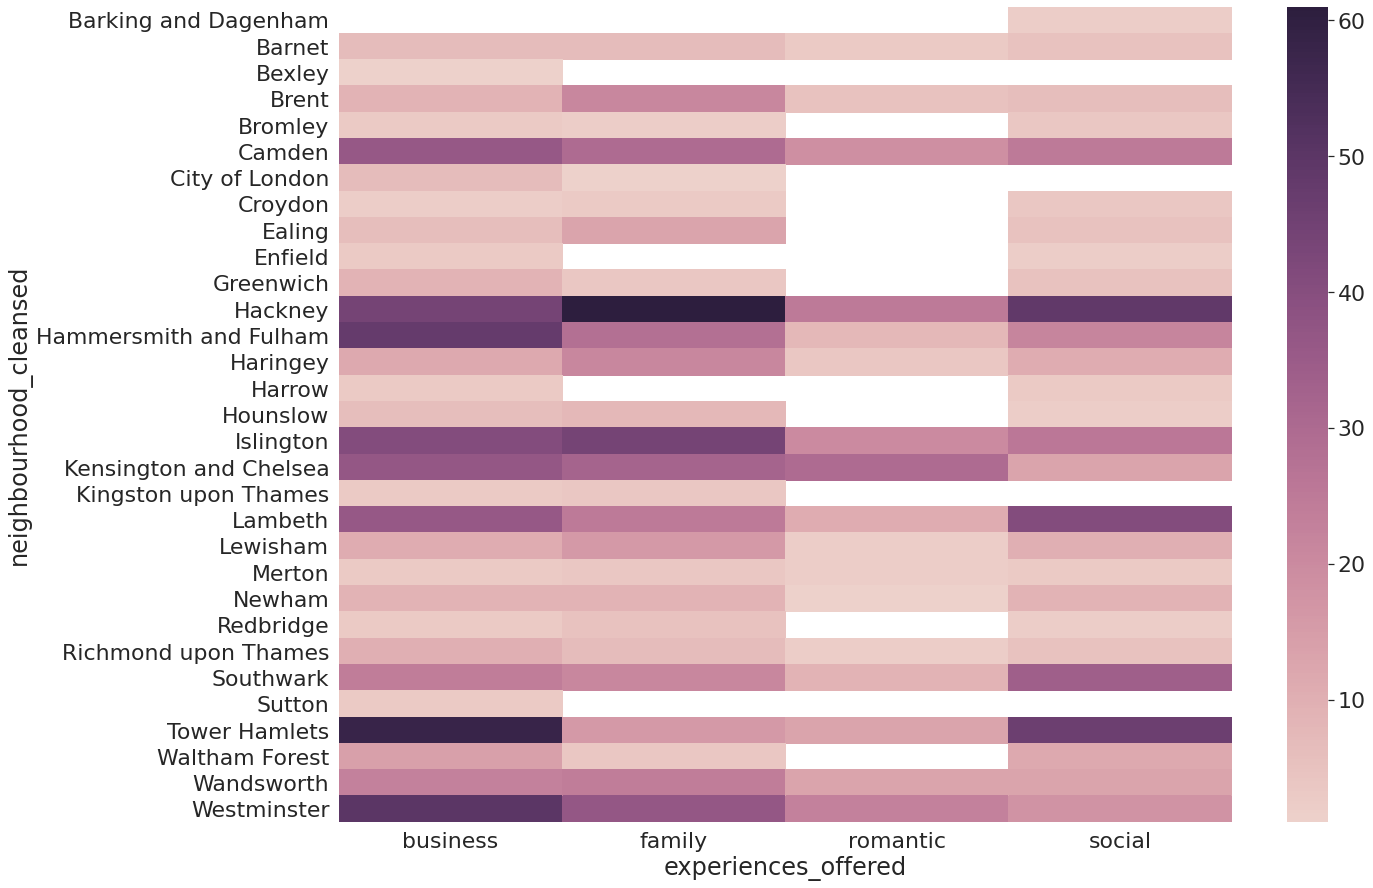

In [176]:
sns.heatmap(df_y, cmap=sns.cubehelix_palette(as_cmap=True))

#### Upload prices per night for different types of accommodation with avaliable entertainment

In [8]:
night_query = '''
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
WHERE experiences_offered != 'none'
'''
night_data = ph.read_clickhouse(night_query, connection=connection_default)
night_data

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


In [9]:
night_data['log(price)'] = np.log(night_data['price'])

In [10]:
night_data

,room_type,price,log(price)
0,Private room,65.0,4.174387
1,Entire home/apt,100.0,4.605170
2,Private room,150.0,5.010635
3,Private room,45.0,3.806663
4,Private room,25.0,3.218876
...,...,...,...
1543,Entire home/apt,100.0,4.605170
1544,Entire home/apt,125.0,4.828314
1545,Entire home/apt,185.0,5.220356
1546,Entire home/apt,110.0,4.700480


In [11]:
night_data.room_type.value_counts()

Entire home/apt    922
Private room       613
Shared room          9
Hotel room           4
Name: room_type, dtype: int64

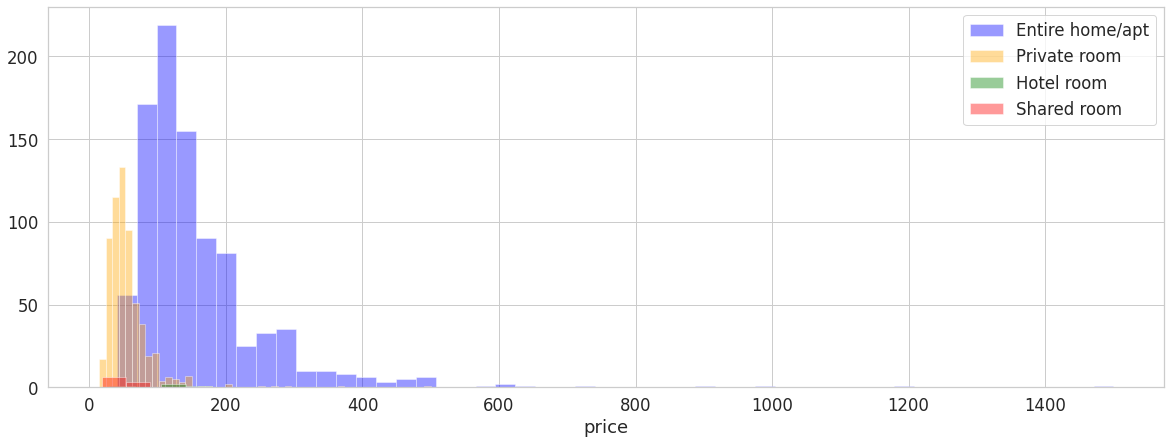

In [16]:
sns.distplot(a=night_data.query('room_type == "Entire home/apt"').price, kde = False, color = 'blue', label = 'Entire home/apt')
sns.distplot(a=night_data.query('room_type == "Private room"').price, kde = False, color = 'orange', label = 'Private room')
sns.distplot(a=night_data.query('room_type == "Hotel room"').price, kde = False, color = 'green', label = 'Hotel room')
sns.distplot(a=night_data.query('room_type == "Shared room"').price, kde = False, color = 'red', label = 'Shared room')

plt.legend()
plt.show()

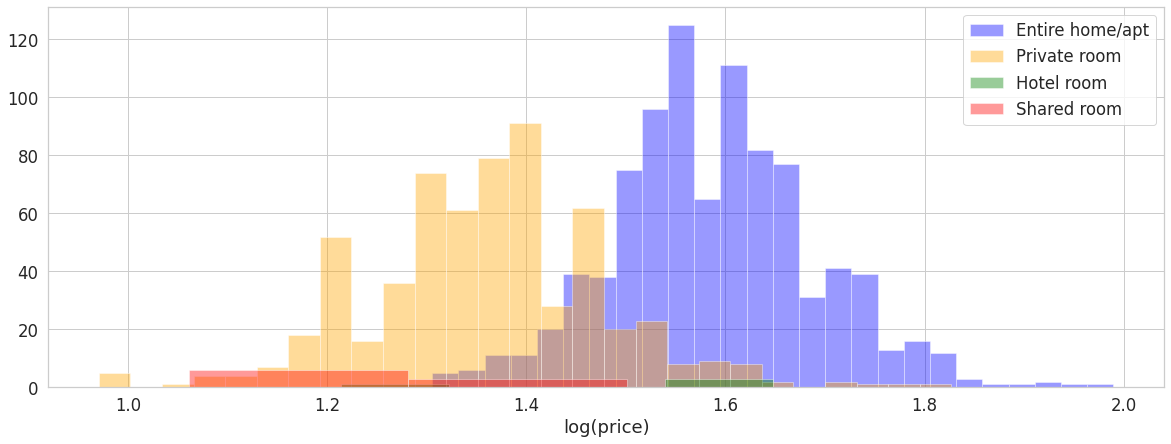

In [17]:
sns.distplot(a=np.log(night_data.query('room_type == "Entire home/apt"')['log(price)']), kde = False, color = 'blue', label = 'Entire home/apt')
sns.distplot(a=np.log(night_data.query('room_type == "Private room"')['log(price)']), kde = False, color = 'orange', label = 'Private room')
sns.distplot(a=np.log(night_data.query('room_type == "Hotel room"')['log(price)']), kde = False, color = 'green', label = 'Hotel room')
sns.distplot(a=np.log(night_data.query('room_type == "Shared room"')['log(price)']), kde = False, color = 'red', label = 'Shared room')

plt.legend()
plt.show()

In [220]:
night_data.room_type.value_counts()

Entire home/apt    187
Private room        94
Shared room          8
Hotel room           3
Name: room_type, dtype: int64

#### Let's take reviews of rooms down by year:

In [56]:
morning_query = '''
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    first_review
FROM ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
'''
morning_data = ph.read_clickhouse(morning_query, connection=connection_default)
morning_data

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [57]:
morning_data['year'] = morning_data.first_review.apply(lambda x: x.split('-')[0])
morning_data = morning_data.drop(columns= 'first_review')
morning_data

,room_type,price,year
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


In [58]:
morning_data.dtypes

room_type     object
price        float32
year          object
dtype: object

In [59]:
# change data type for year:
morning_data['year'] = morning_data['year'].astype('int32')

In [60]:
morning_data.dtypes

room_type     object
price        float32
year           int32
dtype: object

In [61]:
# sort DF by first_review
morning_data = morning_data.sort_values(by='year')

In [62]:
morning_data

,room_type,price,year
0,Private room,65.0,2010
44,Private room,55.0,2010
39,Private room,75.0,2010
38,Entire home/apt,78.0,2010
33,Private room,45.0,2010
...,...,...,...
887,Private room,21.0,2019
277,Private room,105.0,2019
431,Private room,35.0,2019
12,Private room,39.0,2020


In [64]:
morning_data.dtypes

room_type     object
price        float32
year           int32
dtype: object

#### Using seaborn, create the graph of mean prices per room type per year

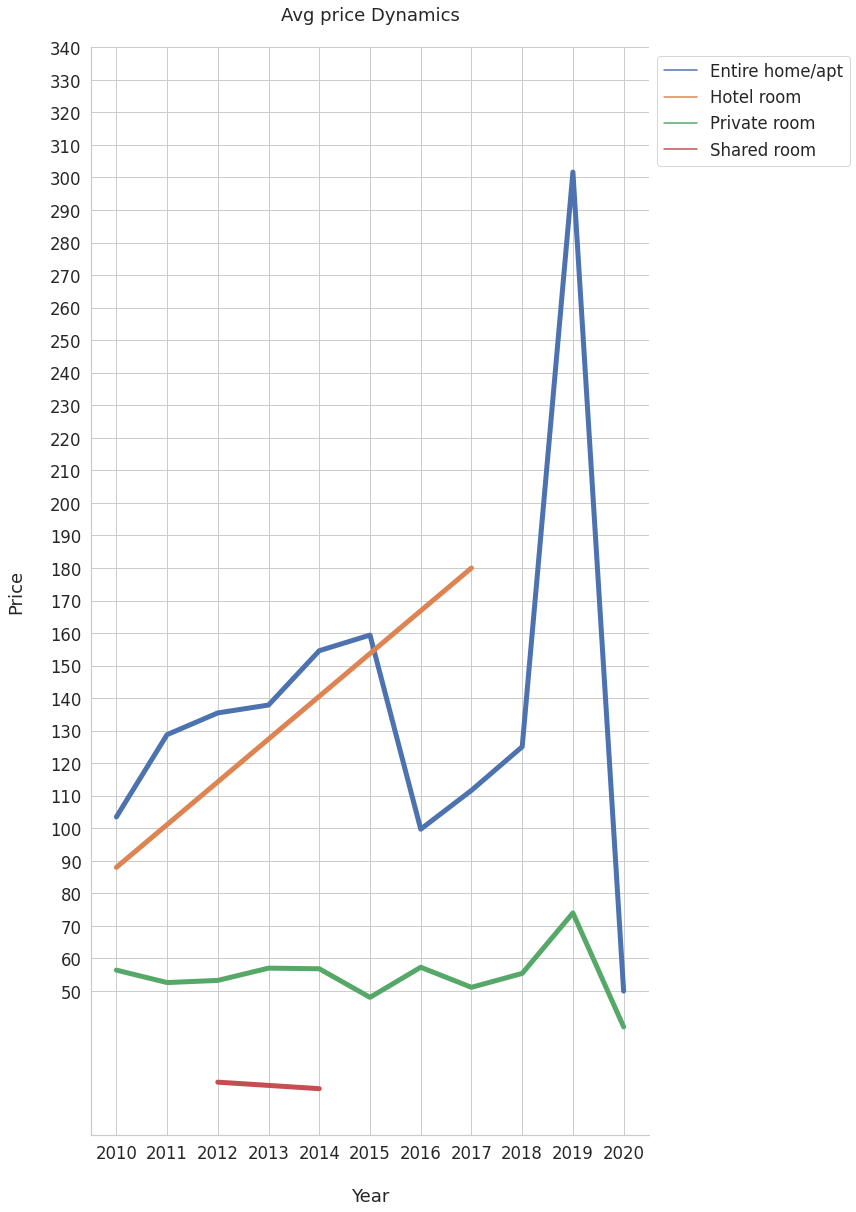

In [110]:
ax = sns.lineplot(data = morning_data, x = 'year', y = 'price', 
                  hue = 'room_type', 
                  hue_order = ['Entire home/apt', 'Hotel room', 'Private room', 'Shared room'],
                  linewidth = 5, 
                  ci = None
                  )

plt.legend(loc = 2, bbox_to_anchor = (1,1))
ax.set(xlabel='\nYear', ylabel='Price\n', title = 'Avg price Dynamics\n')
ax.set_xticks([i for i in range(2010, 2021)])
ax.set_yticks([i for i in range(50, 350, 10)])
sns.despine()